In [267]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import bartlett
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings 
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'Malgun Gothic'
df = pd.read_csv('../csv&excel/feature_select_nolog.csv')
# df = pd.read_csv('../csv&excel/feature_select_logdone.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [268]:
## 장르 get_dummies 후 장르 컬럼 삭제
dummies_genre = pd.get_dummies(df['장르'], prefix='장르')
df = pd.concat([df,dummies_genre], axis=1)
df.drop(['장르'],axis=1,inplace=True)

In [269]:
## logdone파일 시 사용
# from sklearn.model_selection import train_test_split
# labels = df["타겟"]
# features = df.drop(columns=['영화명', '개봉일', '타겟'], axis=1)
# X_train_MM, X_test_MM, Y_train, Y_test = train_test_split(features,labels, test_size=0.3, random_state=156, stratify=labels)

In [270]:
# nolog파일 시 사용
from sklearn.model_selection import train_test_split
labels = df["타겟"]
features = df.drop(columns=['영화명', '개봉일', '타겟'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(features,labels, test_size=0.3, random_state=156, stratify=labels)
# ----------------------------------------------------------------------------------
## minmaxscaler
# from sklearn.preprocessing import MinMaxScaler
# scaler_MM = MinMaxScaler()
# scaler_MM.fit(X_train)
# data_scaled_MM = scaler_MM.transform(X_train)
# X_train_MM = pd.DataFrame(data = data_scaled_MM, columns=X_train.columns)
# scaler_MM.fit(X_train)
# data_scaled_MM_1 = scaler_MM.transform(X_test)
# X_test_MM = pd.DataFrame(data = data_scaled_MM_1, columns=X_test.columns)
## ------------------------------------------------------------------------------
# standardscaler
from sklearn.preprocessing import StandardScaler
scaler_St = StandardScaler()
scaler_St.fit(X_train)
data_scaled_MM = scaler_St.transform(X_train)
X_train_MM = pd.DataFrame(data = data_scaled_MM, columns=X_train.columns)
scaler_St.fit(X_train)
data_scaled_MM_1 = scaler_St.transform(X_test)
X_test_MM = pd.DataFrame(data = data_scaled_MM_1, columns=X_test.columns)

### SelectKBest

In [271]:
#필터방법(SelectKBest)
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# Select the top 10 features based on ANOVA F-value
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X_train_MM, Y_train)

# Get selected feature names
mask = selector.get_support()
selected_features = X_train_MM.columns[mask]

# Create DataFrame with selected features and their p-values
selected_result_1 = pd.DataFrame({'feature': selected_features,
                                'pvalue': selector.pvalues_[mask]})
selected_result_1

,feature,pvalue
0,전국스크린수,0.000051
1,전국관객수,0.004545
2,서울매출액,0.007298
3,서울관객수,0.010481
4,수정전국매출액,0.002731
5,개봉일관객수,0.000342
6,개봉일매출액,0.000261
7,배우가중치,0.060504
8,감독가중치,0.074172
9,국내배급사,0.115460


### T-test

In [272]:
# T-test
# 등분산성 확인 전 레이블 부착
Y_train_t = Y_train.reset_index()
X_train_MM_t = X_train_MM.reset_index()

Y_train_t.drop(columns=['index'], axis=1, inplace=True)
X_train_MM_t.drop(columns=['index'], axis=1, inplace=True)

x_등분산 = pd.concat([X_train_MM_t, Y_train_t], axis=1)
# H가 1인 경우 이분산성 / H가 0인 경우 등분산

def bartlett_test_2(col, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val =bartlett(x_등분산[x_등분산['타겟']==1][i], x_등분산[x_등분산['타겟']==0][i]) 
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    if H == 1:
        a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
    else:
        a = list[(list['p_value'] >= p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
# 이분산성 변수
x_hetero = bartlett_test_2(X_train_MM.columns, H = 1)
# 등분산성 변수
x_homo = bartlett_test_2(X_train_MM.columns, H = 0)
set_이분산 = set(x_hetero["변수"])
set_등분산 = set(x_homo["변수"])

In [273]:
# 2) t_test
def t_test_2(col, col_h0, col_h1, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(x_등분산[x_등분산['타겟']==1][i], x_등분산[x_등분산['타겟']==0][i], equal_var=True) # 등분산성 : wald t-test
            list.append([i, p_val])
        elif (col_h1['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(x_등분산[x_등분산['타겟']==1][i], x_등분산[x_등분산['타겟']==0][i], equal_var=False) # 이분산성 : welch’s t-test
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
    return a

x_ttest = t_test_2(X_train_MM.columns, x_homo, x_hetero, p_value=0.05)
print("유의한 피쳐 수 :", len(x_ttest))
selected_result_2 = x_ttest.sort_values(by="변수", ascending=True)
selected_result_2

유의한 피쳐 수 : 7


,변수,p_value
6,개봉일관객수,0.000439
7,개봉일매출액,0.000328
4,서울관객수,0.011105
3,서울매출액,0.007803
5,수정전국매출액,0.003070
2,전국관객수,0.005011
0,전국스크린수,0.000059


### Stepwise

In [274]:
# stepwise
def stepwise_feature_selection(feature, target, variables):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    import pandas as pd
    warnings.filterwarnings("ignore")
    
    y = target ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.1
    sl_remove = 0.1
    
    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = feature[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.Logit(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = feature[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.Logit(y,selected_X).fit(disp=0).pvalues[1:]
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            presudo_r_squared = sm.Logit(y,sm.add_constant(feature[selected_variables])).fit(disp=0).prsquared
            r_squared.append(presudo_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break
    
    return selected_variables
    
selected_result_3 = stepwise_feature_selection(X_train, Y_train, X_train.columns.tolist())
selected_result_3

['전국스크린수', '개봉일매출비율', '개봉일매출액']

In [275]:
lasso_model = LogisticRegression()
param_grid = {'penalty' : ['l1'], 
                'C' : np.logspace(-4, 4, 20),
                'solver' : ['liblinear', 'saga']}

grid_search = GridSearchCV(lasso_model, param_grid=param_grid, return_train_score=True, cv=5)
grid_search.fit(X_train_MM, Y_train)

df_grid = pd.DataFrame(grid_search.cv_results_)
df_grid = df_grid.sort_values(by=['rank_test_score'], ascending=True)
df_grid[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]
print('GridSearchCV 최적 파라미터:', grid_search.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search.best_score_))

GridSearchCV 최적 파라미터: {'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'saga'}
GridSearchCV 최고 정확도:0.5526


In [276]:
# lasso_best = LogisticRegression(C=0.5, penalty='l1', solver='liblinear').fit(X_train_MM, Y_train)
lasso_best = LogisticRegression(**grid_search.best_params_).fit(X_train_MM, Y_train)
selected_result_4 = pd.DataFrame()
selected_result_4['feature'] = X_train_MM.columns
selected_result_4['coef'] = lasso_best.coef_[0]
selected_result_4.drop(selected_result_4[selected_result_4['coef']==0].index, inplace=True)
selected_result_4

,feature,coef
0,전국스크린수,-0.201766
7,개봉일매출액,-0.076980
8,개봉일매출비율,0.011470
12,등급,-0.016982
13,국내배급사,-0.029148
16,장르_0,-0.010913
17,장르_기타,-0.000901


In [277]:
list_1 = list(selected_result_1['feature'])
list_2 = list(selected_result_2['변수'])
list_3 = list(selected_result_3)
list_4 = list(selected_result_4['feature'])
list_col_all = df.columns

In [278]:
def func_1(x):
    if x in list_1:
        return 1
    else:
        return 0

def func_2(x):
    if x in list_2:
        return 1
    else:
        return 0

def func_3(x):
    if x in list_3:
        return 1
    else:
        return 0
    
def func_4(x):
    if x in list_4:
        return 1
    else:
        return 0

In [279]:
feature_counts = pd.DataFrame()
feature_counts['feature'] = list_col_all
feature_counts['1'] = list_col_all.map(func_1)
feature_counts['2'] = list_col_all.map(func_2)
feature_counts['3'] = list_col_all.map(func_3)
feature_counts['4'] = list_col_all.map(func_4)

feature_counts["total"] = feature_counts["1"]+feature_counts["2"]+feature_counts["3"]+feature_counts["4"]
feature_final = feature_counts[feature_counts["total"]>=2]
list_feature_final = list(feature_final["feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 9


,feature,1,2,3,4,total
0,전국스크린수,1,1,1,1,4
2,전국관객수,1,1,0,0,2
3,서울매출액,1,1,0,0,2
4,서울관객수,1,1,0,0,2
5,수정전국매출액,1,1,0,0,2
6,개봉일관객수,1,1,0,0,2
7,개봉일매출액,1,1,1,1,4
8,개봉일매출비율,0,0,1,1,2
15,국내배급사,1,0,0,1,2


In [280]:
select_final = []
for i in feature_final.index:
    if feature_final.loc[i, "total"] >= 2:
        select_final.append(feature_final.loc[i, 'feature'])
select_final


['전국스크린수',
 '전국관객수',
 '서울매출액',
 '서울관객수',
 '수정전국매출액',
 '개봉일관객수',
 '개봉일매출액',
 '개봉일매출비율',
 '국내배급사']

In [281]:
X_train = X_train_MM[select_final]
X_test = X_test_MM[select_final]
X_train

,전국스크린수,전국관객수,서울매출액,서울관객수,수정전국매출액,개봉일관객수,개봉일매출액,개봉일매출비율,국내배급사
0,1.144212,-0.220304,-0.234599,-0.285834,-0.174467,-0.332645,-0.272783,0.301747,1.391217
1,-0.433835,-0.691905,-0.732103,-0.734044,-0.688684,-0.805927,-0.797962,-1.186476,-0.718795
2,-0.754375,-0.662077,-0.713971,-0.712176,-0.664090,-0.477232,-0.500609,-0.298069,-0.718795
3,1.785294,3.619337,4.204883,4.248896,3.619319,0.839699,0.922776,2.536911,1.391217
4,2.177066,2.142627,2.207235,2.171136,2.189064,1.459568,1.487555,2.576521,1.391217
...,...,...,...,...,...,...,...,...,...
632,-1.022863,-0.370468,-0.368765,-0.344254,-0.395360,-0.656375,-0.654374,-0.150945,-0.718795
633,0.672990,3.477814,4.671638,4.279336,3.836210,-0.030539,-0.092404,-0.213190,1.391217
634,-0.844784,-0.640658,-0.702859,-0.690074,-0.656833,-0.654814,-0.674579,-1.135548,-0.718795
635,-0.680404,-0.356998,-0.251151,-0.212873,-0.386653,-0.494241,-0.501291,0.041449,-0.718795


In [282]:
X_train.to_csv('../csv&excel/X_train.csv', index=0)
X_test.to_csv('../csv&excel/X_test.csv', index=0)
Y_train.to_csv('../csv&excel/Y_train.csv', index=0)
Y_test.to_csv('../csv&excel/Y_test.csv', index=0)

<AxesSubplot: >

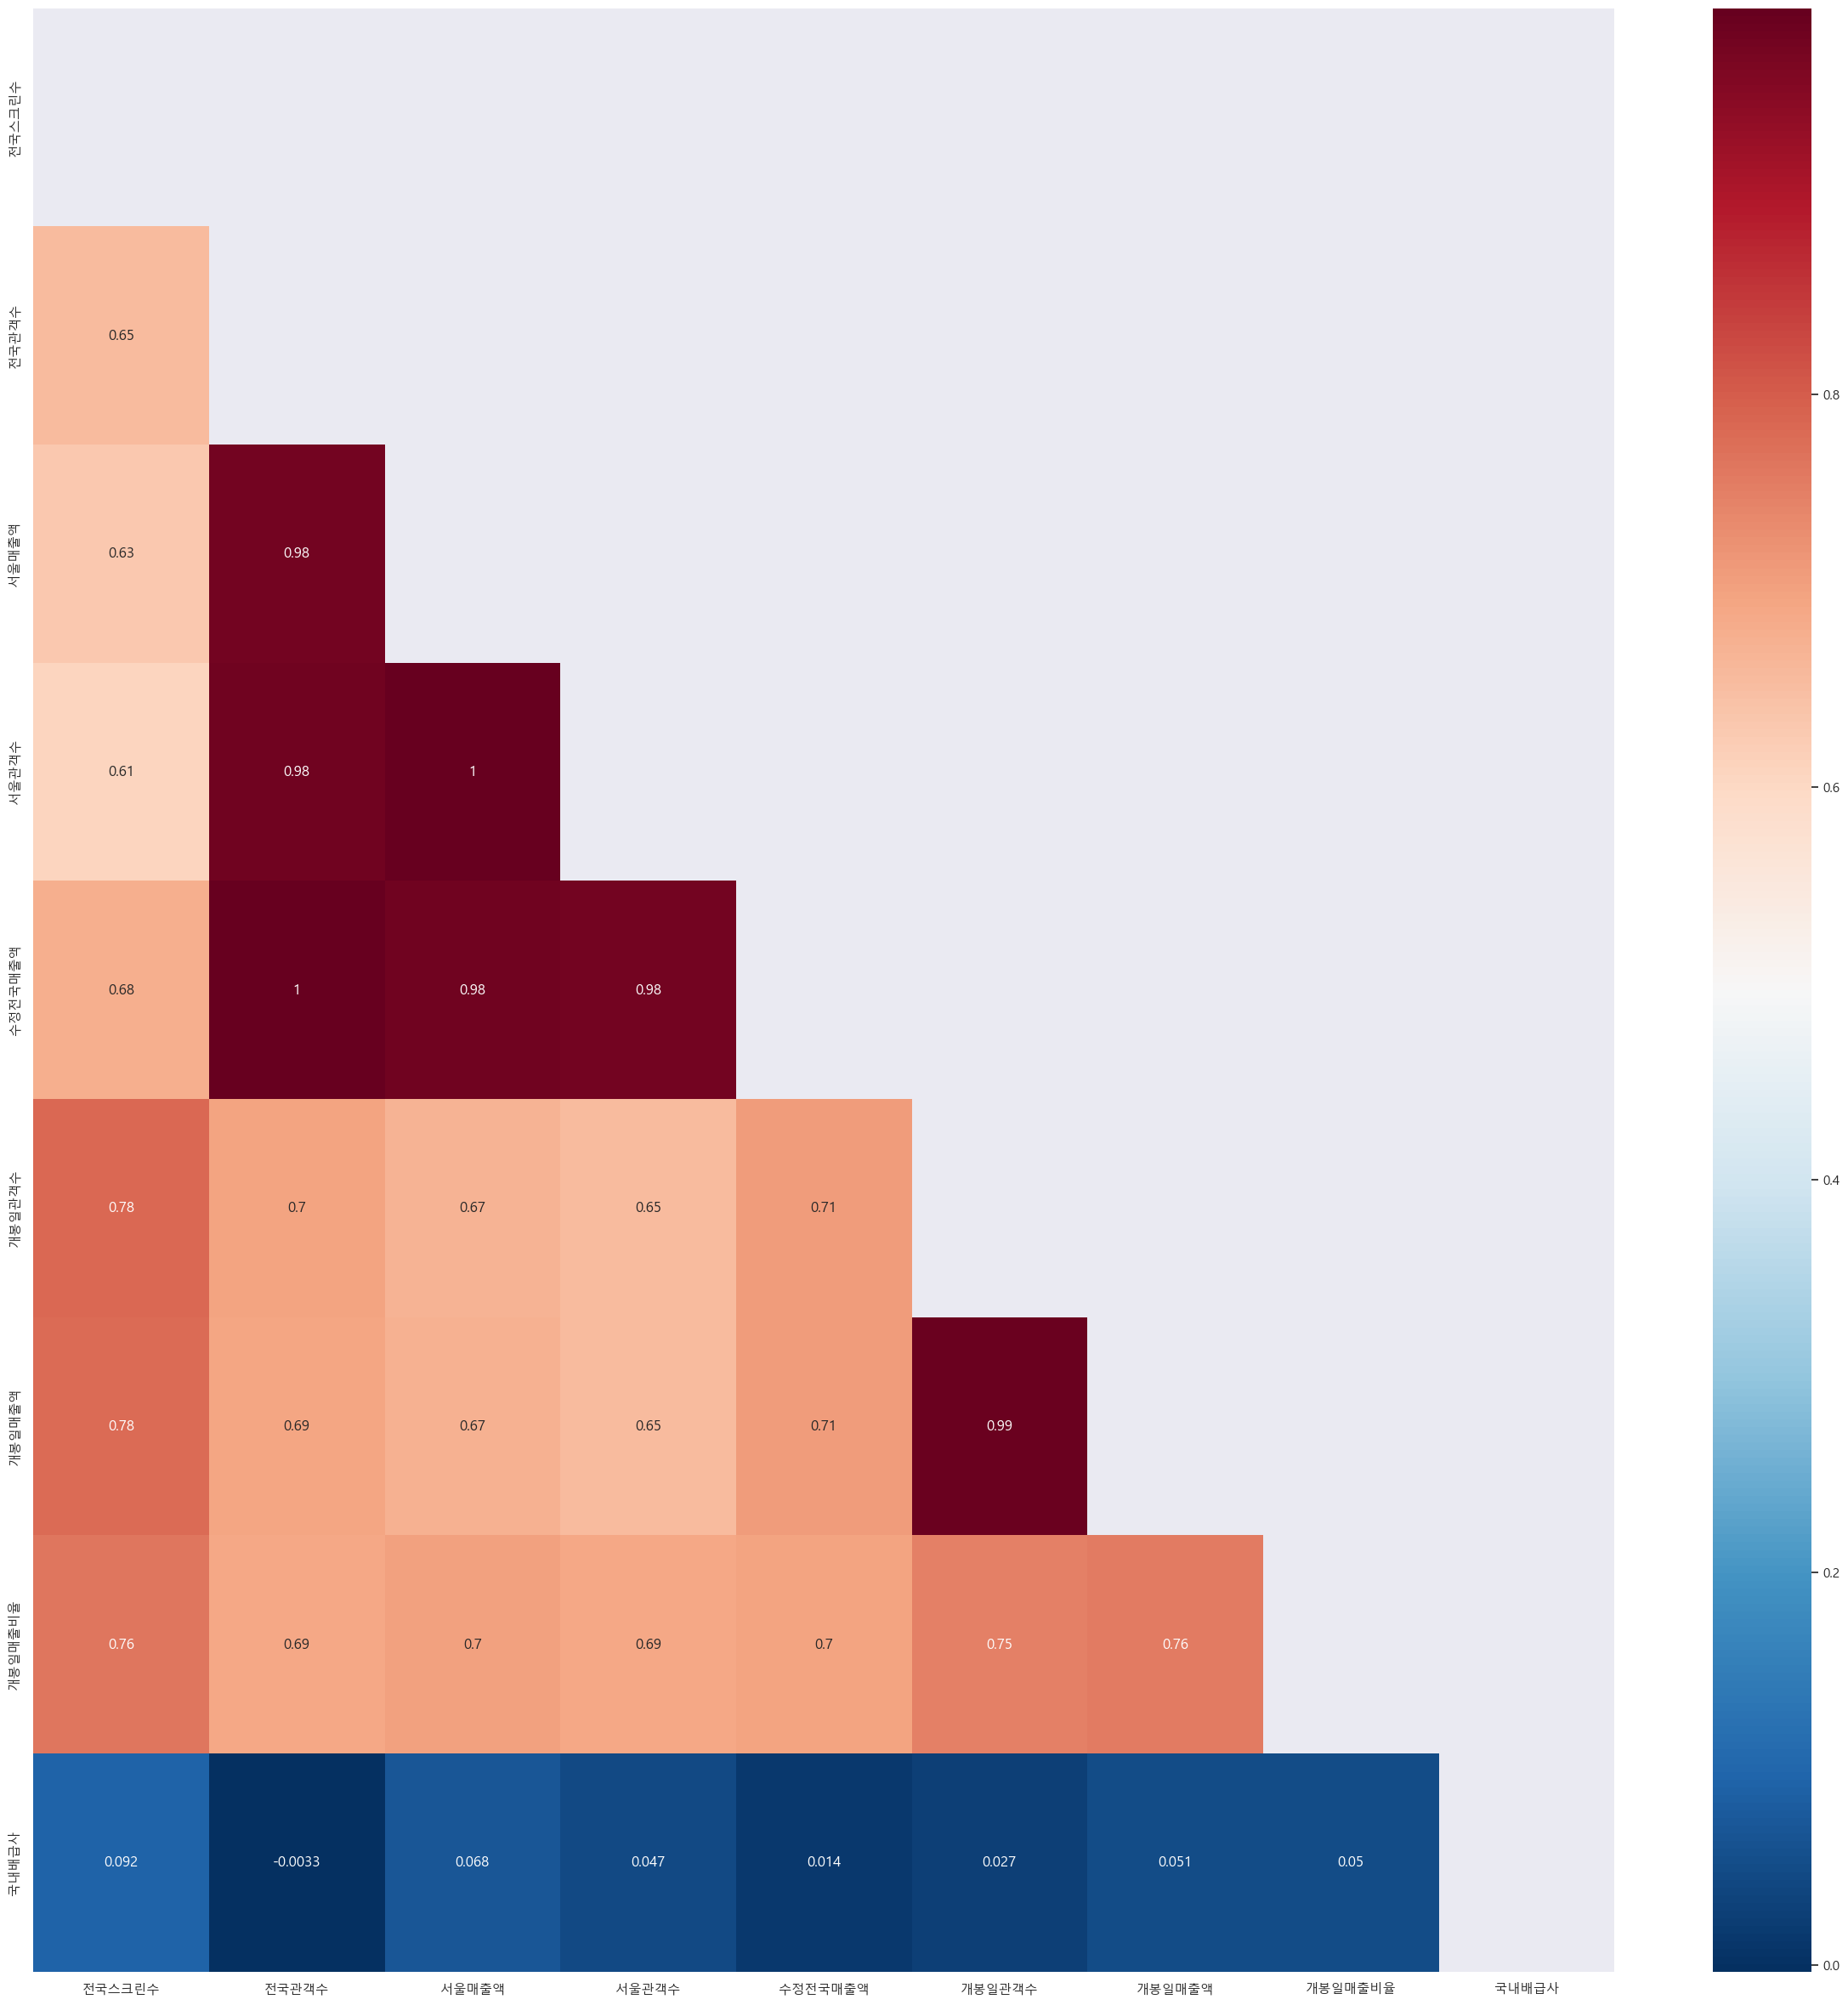

In [283]:
## 선택된 변수들의 상관관계 확인
df_cor = X_train.corr(method='pearson')

sns.set(rc = {'figure.figsize':(30,30)})
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.heatmap(df_cor, xticklabels=df_cor.columns, yticklabels=df_cor.columns, cmap='RdBu_r', annot=True, mask=np.triu(df_cor))

In [284]:
## 다중 공선성 확인
vif_IQR_drop = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif_IQR_drop["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_IQR_drop["features"] = X_train.columns 

# VIF 값이 높은 순으로 정렬
vif_IQR_drop = vif_IQR_drop.sort_values(by="VIF Factor", ascending=False)
vif_IQR_drop = vif_IQR_drop.reset_index().drop(columns='index')
vif_IQR_drop

,VIF Factor,features
0,1849.489814,전국관객수
1,1835.373860,수정전국매출액
2,1567.566964,서울관객수
3,1541.001863,서울매출액
4,68.134304,개봉일매출액
5,67.041397,개봉일관객수
6,4.377991,전국스크린수
7,3.731654,개봉일매출비율
8,1.183351,국내배급사
